# 📝  Challenge 4 - Update Listing Rate Limit

## 1️⃣ Challenge
### 🕵️‍♀️ Investigate Throttling Issue

There seems to be signs of ⚠️ **unusually high** throttle rates since August when we are submitting our **updates** resulting in updates not going through. <br />

## 2️⃣ Rate Limit
Our team has identified that `patchListingsItem` was throttled. 

They went to the [Listings Items API documentation](https://developer-docs.amazon.com/sp-api/docs/listings-items-api-rate-limits) and identified the following rate limits for `patchListingsItem`.

<details>
<summary>Click to see <strong> Rate limit per account-application pair </strong></summary>
<strong>5TPS</strong>
</details>

<details>
<summary>Click to see <strong> Rate limit per application </strong></summary>
<strong>500TPS</strong>
</details>

<details>
<summary>Click to see <strong> Rate limit per application (with relationship updating attributes) </strong></summary>
<strong>100TPS</strong>
    
_*relationship updating attributes: `child_parent_sku_relationship`, `package_contains_sku`*_
</details>

<details>
<summary>Click to see <strong> Rate limit per application (with product data attributes) </strong></summary>
<strong>100TPS</strong>
    
_*Attributes that are not [inventory attributes](https://developer-docs.amazon.com/sp-api/docs/mapping-product-attributes#inventory-feed-mappings), [pricing attributes](https://developer-docs.amazon.com/sp-api/docs/mapping-product-attributes#pricing-feed-mappings) and relationship updating attributes categorize as product data attributes.*_
</details>

## 3️⃣ Visualize Traffic 📊

📊 💻 Cloudwatch Logs Investigation:
```
fields status, @logstream
| filter requesturl like '/listings/2021-08-01/items/' and httpMethod = 'PATCH'
| stats (SUM(status = 429) * 100 / count(*)) as percentagePatchThrottles429 by bin(1h)
```

Let's visualize and see if we can find some clues 🔍.

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


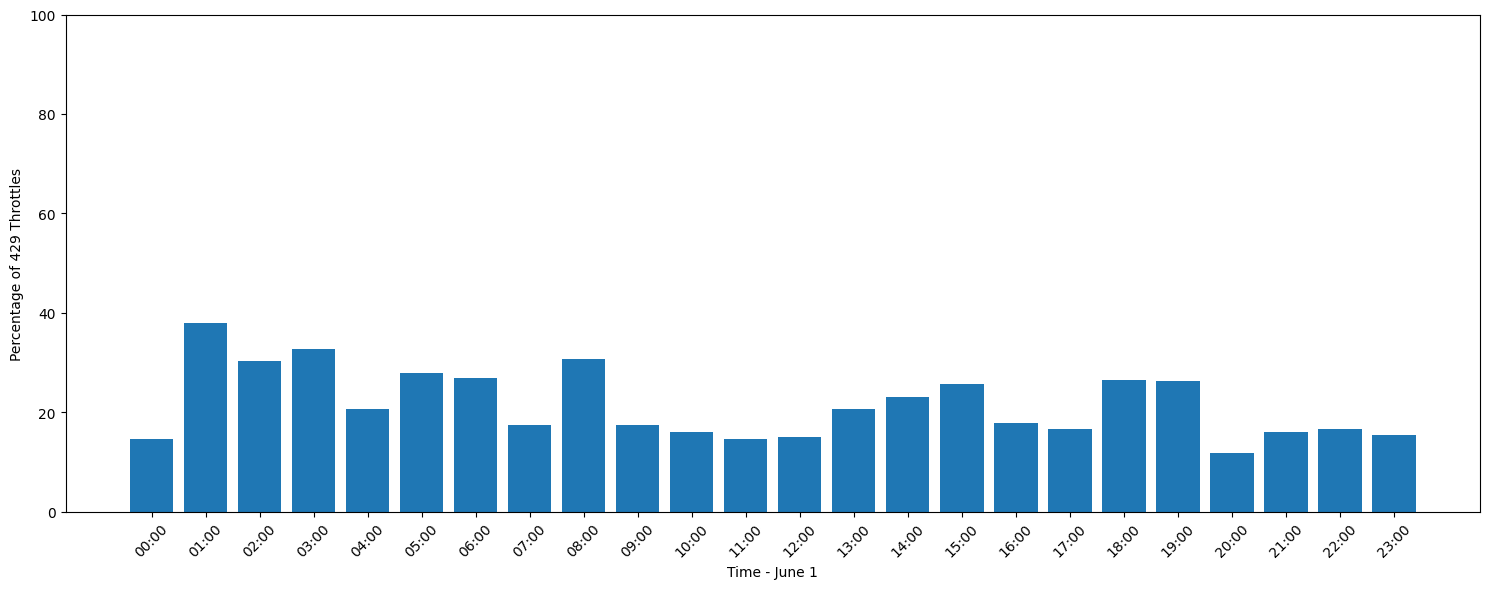

In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
# Load JSON data
with open('throttlepercentage.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)
df['bin(1h)'] = pd.to_datetime(df['bin(1h)'])
df['percentagePatchThrottles429'] = df['percentagePatchThrottles429'].astype(float)

# Sort by time
df = df.sort_values('bin(1h)')

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(range(len(df)), df['percentagePatchThrottles429'])
plt.xlabel('Time - June 1')
plt.ylabel('Percentage of 429 Throttles')
plt.ylim(0, 100)
plt.xticks(range(len(df)), [dt.strftime('%H:%M') for dt in df['bin(1h)']], rotation=45)
plt.tight_layout()
plt.show()

## 4️⃣ Insights in Throttle Messages 💾

🔎 📈 Key Findings:
- Consistent throttling throughout day
- No significant spikes observed

‼️ However, our team noticed that there are different messages received when the requestes were throttled. Here are some examples:
```
{
    "errors":[
        {
            "code": "TOO_MANY_REQUESTS",
            "message": "The frequency of requests was greater than what is allowed for product data."
        }]
}"
```
```
{
    "errors":[
        {
            "code": "TOO_MANY_REQUESTS",
            "message": "The frequency of requests was greater than what is allowed for relationships."
        }]
}"
```

_*The list of throttle messages can be found in [documentation](https://developer-docs.amazon.com/sp-api/docs/listings-items-api-rate-limits)*_

### More Visualization 📊
Can we get the messages in the responses of the requests that ended up in 429s?

```
fields @timestamp, @message
| filter requesturl like '/listings/2021-08-01/items/' and httpMethod = 'PATCH and status = '429'
```

Let's visualize and see if we can find some clues.

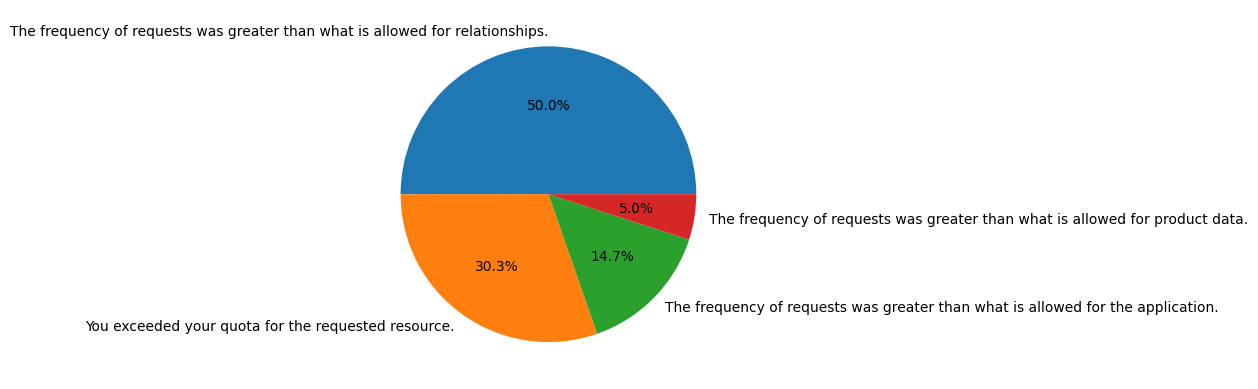

In [90]:
import json
import pandas as pd
import matplotlib.pyplot as plt
with open('sample_log.json', 'r') as f:
    data = json.load(f)
# Example: If 'data' is a list of dictionaries, convert to DataFrame
df = pd.DataFrame([
    {
        "Time": item["@timestamp"],
        "Message": item["@message"]["message"]
    }
    for item in data
])
# Assuming df is your DataFrame with 'Time' and 'status' columns
# First, let's convert the Time to datetime if it's not already
df['Time'] = pd.to_datetime(df['Time'])
# display(df)
# Count occurrences of each message
message_counts = df['Message'].value_counts()

# Create pie chart
plt.pie(message_counts.values, labels=message_counts.index, autopct='%1.1f%%')
plt.show()


## 5️⃣ Submission Content Analysis 

Our team pulled the submissions that are throttled 📑 🔍. Here is an example:

<details>
    
<summary>Click to see <strong> Sample Submission Content </strong></summary>
    
```
{
  "productType": "SHIRT",
  "patches": [
    {
      "op": "replace",
      "path": "/attributes/fulfillment_availability",
      "value": [
        {
          "quantity": 0,
          "fulfillment_channel_code": "DEFAULT",
          "lead_time_to_ship_max_days": 3
        }
      ]
    },
    {
        "op": "add",
        "path": "/attributes/child_parent_sku_relationship",
        "value": [
          {
            "child_relationship_type": "variation",
            "marketplace_id": "ATVPDKIKX0DER",
            "parent_sku": "OVERSIZESHIRT"
          }
        ]
      },
      {
        "op": "add",
        "path": "/attributes/parentage_level",
        "value": [
          {
            "value": "child",
            "marketplace_id": "ATVPDKIKX0DER"
          }
        ]
      }
      ...
  ]
}
```

</details>

---

## 6️⃣ Optimization Strategies ⚡

### 🎯 Strategy 1 - Verify Change

Once relationship establishes on creation, it should rarely be changed during listings updates. 

_*You can go from stand alone listing to being a child listing, or a child listing to stand alone listing. But a parent listing is always a parent listing. It can’t be converted.*_

What could be the reason of such high volume of relationship related updates?


<details>
<summary>Click to see Potential Reason 1 </summary>

    
<strong> ⚠️ Relationship Not Establishing Successfully </strong>

```
{
      "severity": "ERROR",
      "code": "8007",
      "message": "We found some issues with your parent SKU OVERSIZESHIRT that need to be fixed before you can work on any child SKUs. Please correct the product errors in your parent SKU first. For more details please check https://sellercentral.amazon.co.uk/gp/help/202135320",
      "categories": [
        "MISSING_ATTRIBUTE"
      ]
}
```

<strong> Recommendation - Payload Validation ✅ </strong>

The Selling Partner API for [Product Type Definitions](https://developer-docs.amazon.com/sp-api/docs/product-type-definitions-api-v2020-09-01-reference) provides programmatic access to attribute and data requirements for product types in the Amazon catalog. Solution providers can validate the product payload using the Product Type JSON Schema via self-built or publicly available tools, reducing errors that would trigger re-submissions.

</details>

<details>
<summary>Click to see Potential Reason 2 </summary>

<strong>🔄 Duplicated Content </strong>

You seller could be sending duplicated content to you. 

<strong> Recommendation - De-duplication mechanism ✨ </strong>

Implement hashing algorithm: Uses hashing algorithms like SHA-1 or MD5 to generate unique identifiers for data chunks and avoid repeat submissions.
</details>




### 🎯 Strategy 2 - Separate Price and Inventory Updates

If there is indeed a large amount of valid relationship/product data updates and you are encountering throttling. It might be a good idea to separate price and inventory updates versus the rest to ensure urgent updates can go through.

<details>
<summary>Click to see Option 1 </summary>
    
Move relationship and product data updates to `JSON_LISTINGS_FEED` and submit on schedule. Combine updates to ensure maximum efficiency in `JSON_LISTINGS_FEED` size.

</details>

<details>
<summary>Click to see Option 2 </summary>
    
Have back up mechanism to submit price and inventory in the case where the combined submissions failed.

</details>


---

## 7️⃣ BONUS: Traffic Optimization 🚀 ⏰

Instead of making listings submissions as soon as changes happen, consider spreading non-urgent updates through-out the day to avoid exceeding the rate limit of the Listings API and JSON_LISTINGS_FEED and utilize the full capability of the API.

📅 Schedule non-urgent updates

⚡ Spread traffic throughout day

🎯 Maximize API capability usage
